### Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense , GRU , SimpleRNN
from prophet import Prophet
from sklearn.metrics import mean_absolute_error , mean_squared_error , mean_absolute_percentage_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The Electrical dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/appliances+energy+prediction.zip'
extract_path = '/content/drive/MyDrive/extracted_folder'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

csv_path = '/content/drive/MyDrive/extracted_folder/energydata_complete.csv'
df = pd.read_csv(csv_path)
df_t = df[["Appliances"]]
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')

Mounted at /content/drive


## Splitting of Data in 70:20:10 for ( training , validation , testing ) sets

In [ ]:
# The result is a dictionary, column_indices, where the keys are the column names of df, and the values are their respective indices in the column list.
# This dictionary can be used to quickly access the index of a column based on its name, which can be useful for various oprs such as column rearrangement,selec. or manip.
column_indices = {name: i for i, name in enumerate(df_t.columns)}

n = len(df_t)
train_df = df_t[0:int(n*(70/100))]
val_df = df_t[int(n*(70/100)):int(n*(90/100))]
test_df = df_t[int(n*(90/100)):]

num_features = df_t.shape[1]
# print(num_features)

## Normalize the data

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
train_df.size

13814

### Adding Date of datetime type as prophet required

In [ ]:
train_df['ds'] = date_time[:int(n*(70/100))]
val_df['ds'] = date_time[int(n*(70/100)):int(n*(90/100))]
test_df['ds'] = date_time[int(n*(90/100)):]

In [ ]:
train_df = train_df.rename(columns = {'Appliances' : 'y'} )
val_df = val_df.rename(columns = {'Appliances' : 'y'} )
test_df = test_df.rename(columns = {'Appliances' : 'y'} )

In [ ]:
train_df.head()

,y,ds
0,-0.362869,2016-01-11 17:00:00
1,-0.362869,2016-01-11 17:10:00
2,-0.456451,2016-01-11 17:20:00
3,-0.456451,2016-01-11 17:30:00
4,-0.362869,2016-01-11 17:40:00


### visualizing the data

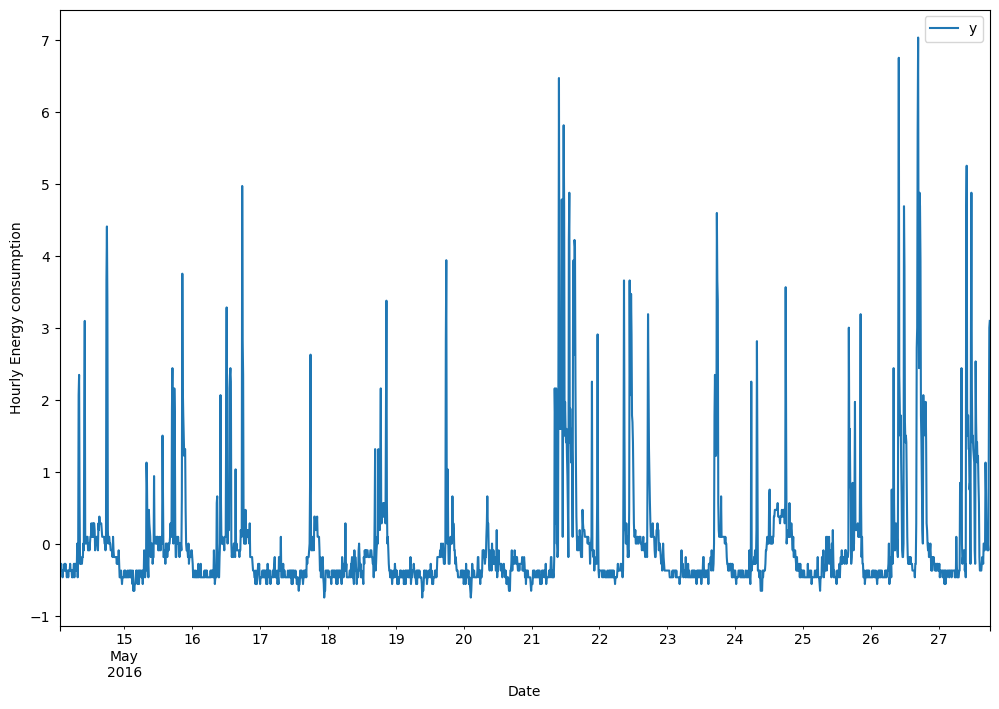

In [ ]:
ax = test_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Hourly Energy consumption')
ax.set_xlabel('Date')

plt.show()

## Prophet

In [ ]:
prophet = Prophet(interval_width = 0.95)

In [ ]:
prophet.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpur_pr73w/xlol7lrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpur_pr73w/dpbq0t28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62989', 'data', 'file=/tmp/tmpur_pr73w/xlol7lrl.json', 'init=/tmp/tmpur_pr73w/dpbq0t28.json', 'output', 'file=/tmp/tmpur_pr73w/prophet_modelbzma9cud/prophet_model-20230710084921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = prophet.make_future_dataframe(periods = 0, freq='H')

# instructed prophet to create 24 datestamps into future
# we are looking to predict future values of our time series 24 hours into the future.

future_dates.head()

,ds
0,2016-01-11 17:00:00
1,2016-01-11 17:10:00
2,2016-01-11 17:20:00
3,2016-01-11 17:30:00
4,2016-01-11 17:40:00


In [ ]:
forecast = prophet.predict(future_dates)

In [ ]:
mse = mean_squared_error(train_df['y'] , forecast['yhat'])
mae = mean_absolute_error(train_df['y'] , forecast['yhat'])
mape = mean_absolute_percentage_error(train_df['y'] , forecast['yhat'])

In [ ]:
forecast['yhat'].size

13814

In [ ]:
train_df['y'].size

13814

In [ ]:
mse

0.8349135439388142